In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Definir rutas de directorios de datos
train_dir = './DATA/TRAIN'
val_dir = './DATA/VAL'
test_dir = './DATA/TEST'

In [3]:
# Dimensiones de las imágenes
img_width, img_height = 224, 224

In [4]:
# Configurar el preprocesamiento de imágenes y generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)


Found 4020 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 39 images belonging to 3 classes.


In [5]:
# Definir modelo VGG16 pre-entrenado sin la capa densa superior
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

58889256/58889256 [==============================] - 8s 0us/step


In [6]:
# Agregar capas densas superiores personalizadas
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

In [7]:
# Unir el modelo base y las capas densas personalizadas
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
# Congelar los pesos del modelo base
for layer in base_model.layers:
    layer.trainable = False

In [9]:
# Compilar modelo
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

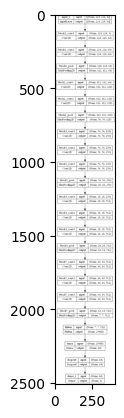

In [11]:
from keras.utils.vis_utils import plot_model

# Mostrar arquitectura del modelo en imagen
plot_model(model, to_file='VGG16.png', show_shapes=True, show_layer_names=True)
img = plt.imread('VGG16.png')
plt.imshow(img)
plt.show()

In [ ]:
import networkx as nx
from keras.utils.vis_utils import model_to_dot

# Crear el grafo de networkx a partir del modelo
graph = nx.DiGraph()
for layer in model.layers:
    if hasattr(layer, 'output'):
        for output_node in layer.output:
            graph.add_edge(layer.name, output_node.name)

# Crear el grafo de matplotlib a partir del grafo de networkx
pos = nx.nx_agraph.graphviz_layout(graph, prog='dot')
nx.draw_networkx_nodes(graph, pos, node_size=500)
nx.draw_networkx_edges(graph, pos, arrows=True)
nx.draw_networkx_labels(graph, pos, font_size=10, font_family='sans-serif')

# Mostrar el grafo
plt.axis('off')
plt.show()

In [ ]:
# Definir callbacks
early_stop = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

In [ ]:
# Entrenar modelo
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stop, checkpoint])

In [ ]:
# Graficar la curva de pérdida
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

# Graficar la curva de precisión
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.show()

In [ ]:
# Graficar resultados de entrenamiento y evaluación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Evaluar modelo con conjunto de prueba
model.load_weights('best_model.h5')
test_loss, test_acc = model.evaluate_generator(test_generator)
print('Test accuracy:', test_acc)

In [ ]:
import sklearn.metrics as metrics
from metrics import confusion_matrix

# Obtener las etiquetas predichas para los datos de prueba
y_pred = modelo.predict(test_generator)

# Convertir las etiquetas predichas en clases (0 o 1) mediante umbral de 0.5
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtener las verdaderas clases para los datos de prueba
y_true = test_generator.classes

# Obtener la lista de etiquetas (nombres de las clases) a partir del generador
class_labels = list(test_generator.class_indices.keys())

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Imprimir la matriz de confusión
print('Matriz de confusión:')
print(confusion_mtx)

In [ ]:
from metrics import classification_report

# Cargar los pesos del modelo
model.load_weights('best_model.h5')

# Obtener las predicciones del modelo en el conjunto de prueba
predictions = model.predict_generator(test_generator)

# Obtener las etiquetas verdaderas del conjunto de prueba
true_labels = test_generator.classes

# Obtener el reporte de clasificación para cada clase
report = classification_report(true_labels, np.argmax(predictions, axis=1), target_names=test_generator.class_indices.keys(), output_dict=True)

# Crear una figura de barras para la precisión, recuperación y puntuación F1
fig, ax = plt.subplots(figsize=(8, 5))
ind = np.arange(len(report.keys())-3)
width = 0.25

for i, metric in enumerate(['precision', 'recall', 'f1-score']):
    scores = [report[label][metric] for label in test_generator.class_indices.keys()]
    ax.bar(ind+i*width, scores, width, label=metric)

ax.set_xticks(ind + width)
ax.set_xticklabels(test_generator.class_indices.keys())
ax.set_ylim([0, 1.0])
ax.set_xlabel('Clases')
ax.set_ylabel('Valor')
ax.legend()

plt.show()

In [ ]:
# Función para predecir una imagen
def classify_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    prediction = model.predict(x)[0]

    classes = ['Normal', 'Neumonia_Bacteria', 'Neumonia_Virus']
    for i in range(len(classes)):
        print(f'{classes[i]}: {prediction[i] * 100:.2f}%')

    predicted_class = np.argmax(prediction)

    return classes[predicted_class]

In [ ]:
def classify_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    prediction = model.predict(x)[0]

    classes = ['Normal', 'Neumonia_Bacteria', 'Neumonia_Virus']
    predicted_class = np.argmax(prediction)

    # Crear dos subplots: uno para la imagen y otro para las probabilidades
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Mostrar la imagen en el primer subplot
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('Imagen')

    # Crear una lista de colores para las barras de las probabilidades
    colors = ['g' if i == predicted_class else 'r' for i in range(len(classes))]

    # Mostrar las probabilidades en un gráfico de barras horizontal en el segundo subplot
    ax2.barh(classes, prediction * 100, color=colors)
    ax2.set_xlim([0, 100])
    ax2.set_title('Probabilidades')
    ax2.set_xlabel('%')

    # Ajustar los subplots y mostrar la figura
    plt.tight_layout()
    plt.show()

    return classes[predicted_class]